In [1]:
import nltk
from nltk import FreqDist
# nltk.download('stopwords')

import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:

import pickle
pickle_in = open("data-model/scrapped_df_other.pkl","rb") 
df = pickle.load(pickle_in) 

df.head(1)

,keywords,title,url,description,pubdate,urlToImage,category
0,"said,mr,bacon,government,relief","'A slap in the face': This family has received just $1,280 two months after their home burned down",http://www.abc.net.au/news/2020-01-17/bushfire-recovery-financial-aid-too-little-too-late/11869252,Updated January A bushfire wiped out Al Bacon's town and left him with serious burns two months ago but he says it may as well have happened yesterday.Ti...,2020-01-16T18:13:42Z,https://www.abc.net.au/news/image/11693498-16x9-700x394.jpg,general


/home/arjun/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/home/arjun/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


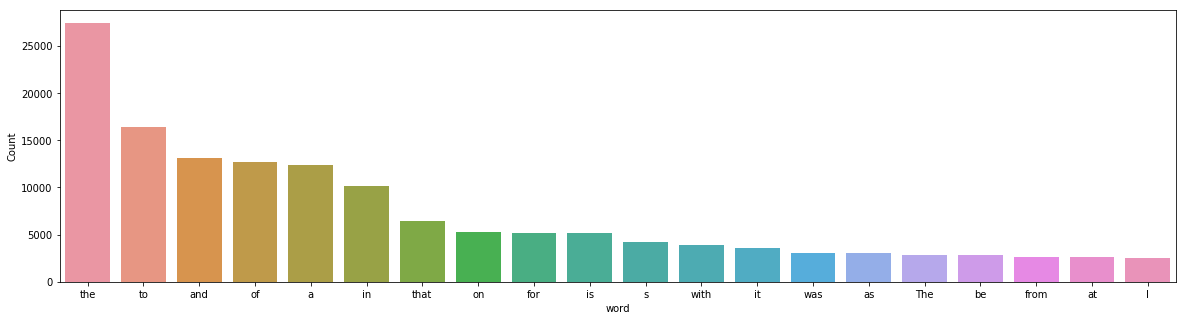

In [3]:
# function to plot most frequent terms

def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()
    
freq_words(df['description'], 20)

In [4]:
# remove unwanted characters, numbers and symbols
df['description'] = df['description'].str.replace("[^a-zA-Z#]", " ")

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['news', 'top', 'policy', 'post', 'long', 'first', 'told', 'uploads', 'root', 'year', 'summary', 'back', 'name', 'span', 'data', 'new', 'time', 'one', 'last', 'jpg', 'img', 'png', 'html', 'width', 'content', 'text', 'two', 'video', 'source', 'paragraph', 'true', 'style', 'title', 'but', 'height', 'div', 'strong', 'image', 'com', 'href', 'class', 'https', 'www', 'amp', 'said', 'would', 'http', 'src', 'target', 'blank', 'get', 'like', 'blank', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['description'] = df['description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['description']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]
type(reviews[0])

str

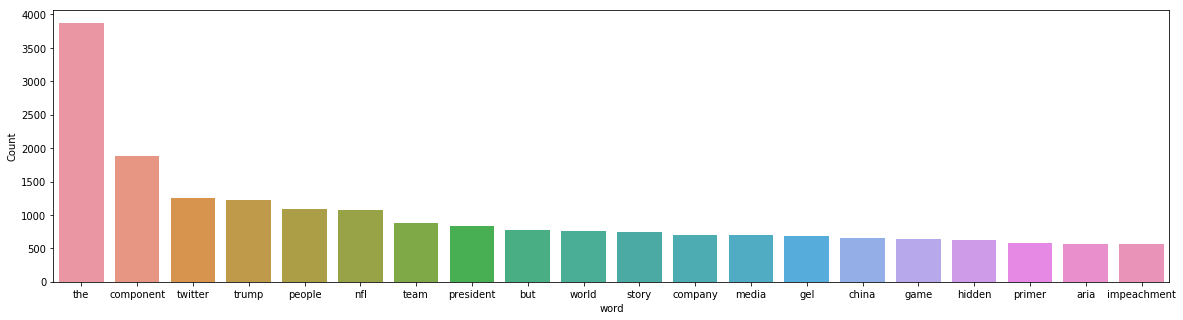

In [95]:
freq_words(reviews, 20)

In [96]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[0])

['published', 'updated', 'timestamp', 'january', 'bushfire', 'wiped', 'bacons', 'town', 'left', 'serious', 'burns', 'months', 'ago', 'says', 'well', 'happened', 'yesterday', 'time', 'hasnt', 'changed', 'much', 'wytaliba', 'north', 'eastern', 'nsw', 'town', 'nsw', 'bushfires', 'inside', 'small', 'town', 'wiped', 'wytaliba', 'self', 'bushfire', 'november', 'killed', 'people', 'destroyed', 'dozens', 'homes', 'buildings', 'bacon', 'uninsured', 'lost', 'everything', 'except', 'baby', 'photos', 'clothes', 'disgusted', 'small', 'amount', 'relief', 'funds', 'family', 'received', 'far', 'partner', 'son', 'paid', 'grant', 'state', 'government', 'relief', 'fund', 'its', 'much', 'slap', 'face', 'fire', 'young', 'father', 'bacon', 'among', 'lost', 'everything', 'recent', 'bushfires', 'financial', 'assistance', 'welcomed', 'little', 'arriving', 'late', 'wytaliba', 'rural', 'fire', 'service', 'firefighter', 'joe', 'borgia', 'struggling', 'find', 'funds', 'rebuild', 'home', 'three', 'firefighters', 'c

In [97]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[0]) # print lemmatized review

['bushfire', 'bacon', 'town', 'serious', 'burn', 'month', 'yesterday', 'time', 'much', 'wytaliba', 'town', 'small', 'town', 'self', 'people', 'home', 'building', 'baby', 'photo', 'clothe', 'small', 'amount', 'relief', 'fund', 'family', 'far', 'partner', 'son', 'state', 'government', 'relief', 'fund', 'much', 'slap', 'face', 'fire', 'young', 'recent', 'bushfire', 'financial', 'assistance', 'little', 'late', 'wytaliba', 'fire', 'firefighter', 'fund', 'home', 'firefighter', 'terrifying', 'firestorm', 'wytaliba', 'event', 'unable', 'sleep', 'week', 'federal', 'government', 'disaster', 'recovery', 'payment', 'month', 'fund', 'government', 'dollar', 'day', 'daughter', 'temporary', 'accommodation', 'glen', 'inne', 'live', 'wytaliba', 'loss', 'hell', 'kit', 'home', 'property', 'feel', 'bit', 'money', 'wytaliba', 'resident', 'thank', 'day', 'thing', 'disaster', 'relief', 'grant', 'bacon', 'family', 'financial', 'assistance', 'response', 'aware', 'federal', 'government', 'disaster', 'recovery', 

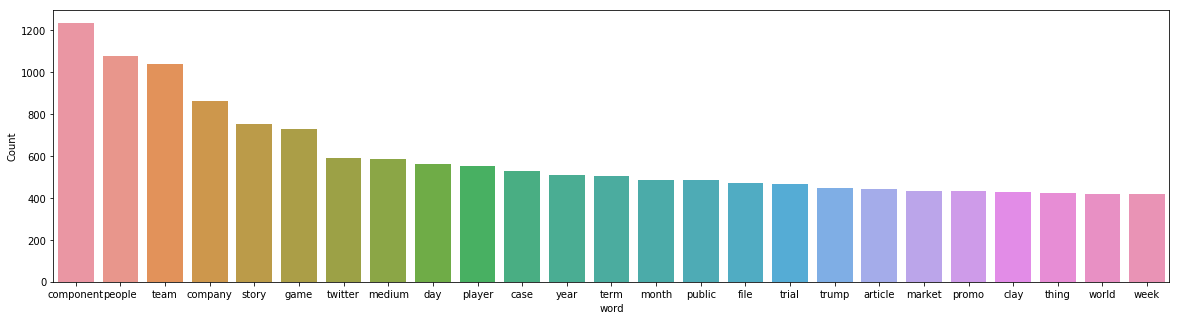

In [99]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 25)

In [100]:
dictionary = corpora.Dictionary(reviews_2)

In [101]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [103]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=50, random_state=100,
                chunksize=1000, passes=50)

In [104]:
lda_model.print_topics()

[(28,
  '0.039*"youtube" + 0.028*"viewer" + 0.018*"draft" + 0.017*"big" + 0.016*"sport" + 0.014*"espn" + 0.011*"video" + 0.010*"twitch" + 0.009*"league" + 0.007*"exclusive"'),
 (7,
  '0.086*"team" + 0.014*"ad" + 0.013*"number" + 0.013*"false" + 0.013*"requiresizeadjustment" + 0.013*"supportsflashvideo" + 0.013*"vast" + 0.013*"season" + 0.013*"video" + 0.012*"position"'),
 (39,
  '0.030*"fire" + 0.023*"plane" + 0.021*"aircraft" + 0.013*"crash" + 0.013*"people" + 0.013*"stat" + 0.010*"season" + 0.009*"service" + 0.008*"australian" + 0.008*"total"'),
 (44,
  '0.053*"clay" + 0.037*"word" + 0.036*"nymag" + 0.035*"intelligencer" + 0.033*"instance" + 0.012*"count" + 0.008*"people" + 0.006*"music" + 0.006*"company" + 0.006*"term"'),
 (38,
  '0.060*"game" + 0.017*"player" + 0.012*"cyberpunk" + 0.010*"release" + 0.009*"developer" + 0.009*"label" + 0.008*"compact" + 0.007*"story" + 0.007*"box" + 0.007*"character"'),
 (26,
  '0.024*"royal" + 0.013*"weinstein" + 0.012*"money" + 0.011*"family" + 0.0